<a href="https://colab.research.google.com/github/StratosFair/Mean_Escape_Time/blob/main/Double_Well_2D/Models/%5BWIP%5Dboundary_adapted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
# Install FEniCS and mshr
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [65]:
# Imports & FP64
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from fenics import *
import mshr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

# Solving for the MET of a given SDE in an ellipse with "Adapted Architecture PINNs" : comparison with numerical solution

## 1) Setup

Let $
\Omega := \{ (x,y)\in\mathbb{R}^2 : (x/2)^2 + (y/1.5)^2 < 1 \}$ be the ellipse centered at the origin with semi-axes $2$ (along $x$) and $1.5$ (along $y$). We consider a process driven by the double-well potential

$$
\Phi(x,y):= A\Bigl( 1-\exp\Bigl(-\frac{(x-1)^2+(y-0.5)^2}{\nu^2}\Bigr)\Bigr)
\Bigl( 1-\exp\Bigl(-\frac{(x+1)^2+(y-0.5)^2}{\nu^2}\Bigr)\Bigr),
$$  
with parameters $A>0$ (which controls the barrier height) and $\nu>0$ (which controls the width of the wells). Its associated drift is given by the negative gradient,
$$
b(x,y)= -\nabla\Phi(x,y)= \begin{pmatrix} b_1(x,y) \\ b_2(x,y) \end{pmatrix}.
$$

The stochastic differential equation solved by our process takes the form
$$
\begin{cases}
dX_t = b(X_t)\,dt + \sigma(X_t)\,dW_t,\\
X_0 = x\in\Omega,
\end{cases}
$$  
where the diffusion matrix is chosen as  
$$
\sigma(x,y)= \begin{pmatrix}
\sqrt{2\epsilon} & 0 \\
0 & \sqrt{\epsilon}
\end{pmatrix}
$$  
for some $\epsilon>0$, and $W_t$ is a two-dimensional standard Brownian motion.

For all $x\in\Omega$, we define the exit time
$$
T(x):=\inf\{t\ge 0: X_t\in\partial\Omega\},
$$  
and denote by
$$
\tau(x):=\mathbb{E}[T(x)]
$$  
its first moment (the mean exit time).

In this setting, one can show that $\tau$ is the (unique) solution of the boundary value problem
$$
\begin{cases}
-\mathcal{L} u(x) = 1 \quad \text{for all } x\in\Omega,\\[1mm]
u(x)= 0 \quad \text{for all } x\in\partial\Omega,
\end{cases}
$$  
where the infinitesimal generator $\mathcal{L}$ is given by
$$
\mathcal{L} u(x) = \epsilon\, u_{xx}(x) + \frac\epsilon2\, u_{yy}(x) + b_1(x,y)\, u_x(x) + b_2(x,y)\, u_y(x).
$$

**Derivation of the Weak Formulation:**

Multiplying the strong form of the PDE
$$
\epsilon\, u_{xx} + \frac\epsilon2\, u_{yy} + b_1\, u_x + b_2\, u_y = -1 \quad \text{in } \Omega,
$$  
by a test function $v\in H^1_0(\Omega)$ and integrating over $\Omega$, we obtain
$$
\int_\Omega \Bigl[ \epsilon\, u_{xx} +\frac\epsilon2\, u_{yy} + b_1\, u_x + b_2\, u_y \Bigr] v\,dx\,dy = -\int_\Omega v\,dx\,dy.
$$  
Integration by parts on the second derivative terms (with $v=0$ on $\partial\Omega$) yields
$$
\int_\Omega \Bigl(\epsilon\, u_x\, v_x + \frac\epsilon2\, u_y\, v_y \Bigr) dx\,dy - \int_\Omega \Bigl( b_1\, u_x + b_2\, u_y \Bigr) v\,dx\,dy = \int_\Omega v\,dx\,dy.
$$  
This is the weak formulation that we discretize using a Galerkin finite element method.

Since no closed-form solution is available, we will use a finite-difference method to compute a reference solution.

In [76]:

# Parameters controlling the double-well potential and diffusion.
#numpy version
A_np = 5.0      # Barrier height for the double-well potential
nu_np = 0.2     # Width parameter of the wells in the potential
eps_np = 1.0    # Diffusion parameter
#fenics version
A = Constant(A_np)         # Barrier height for the double-well potential
nu = Constant(nu_np)        # Width parameter of the wells in the potential
epsilon = Constant(eps_np)   # Diffusion parameter

# Create the elliptical domain Omega
domain = mshr.Ellipse(Point(0.0, 0.0), 2.0, 1.5)
mesh = mshr.generate_mesh(domain, 64)  # Adjust the resolution as needed

# FE function space and boundary conditions
V = FunctionSpace(mesh, "CG", 1)

# Homogeneous Dirichlet BC (u = 0 on the boundary)
u_D = Constant(0.0)
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, u_D, boundary)

# Define the double-well potential and drift field
# using the spatial coordinates (x,y) from the mesh
x_coord = SpatialCoordinate(mesh)

# Double-well potential defined by:
#   Φ(x,y) = A [1 - exp(-((x-1)²+(y-0.5)²)/ν²)] [1 - exp(-((x+1)²+(y-0.5)²)/ν²)]
Phi = A * (1 - exp(-(((x_coord[0]-1)**2 + (x_coord[1]-0.5)**2) / (nu**2)))) \
        * (1 - exp(-(((x_coord[0]+1)**2 + (x_coord[1]-0.5)**2) / (nu**2))))

# The drift b(x,y) is the negative gradient of the potential.
b = -grad(Phi)
b1 = b[0]
b2 = b[1]

# Define the variational problem
u = TrialFunction(V)
v = TestFunction(V)

# The weak formulation reads:
# (ε u_x v_x + (ε/2) u_y v_y) dx - (b₁ u_x + b₂ u_y) v dx = ∫_Ω v dx

a_form = (epsilon * u.dx(0) * v.dx(0) + (epsilon/2) * u.dx(1) * v.dx(1)
          - (b1 * u.dx(0) + b2 * u.dx(1)) * v) * dx
L_form = v * dx

# Solve the problem
u_sol = Function(V)
solve(a_form == L_form, u_sol, bc)

# ------------------------
# Now u_h is the finite element solution (function of x and y)
# Example: Evaluating the solution at a specific point (x0, y0):
pt = (0.0, 0.0)  # Example point at the center of the domain
value_at_pt = u_sol(pt)
print("The solution u_sol at point {} is: {}".format(pt, value_at_pt))

# u_h can be used later in your code for additional computations.

The solution u_sol at point (0.0, 0.0) is: 4.40386809929881


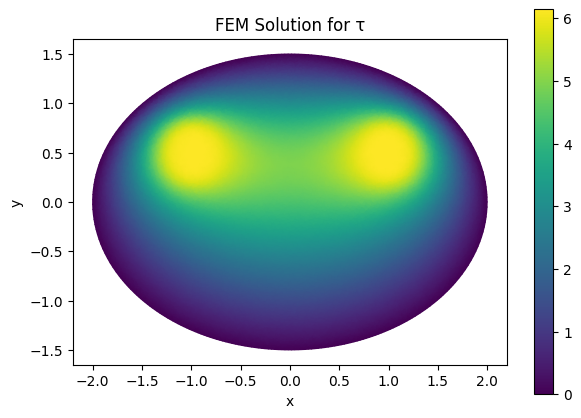

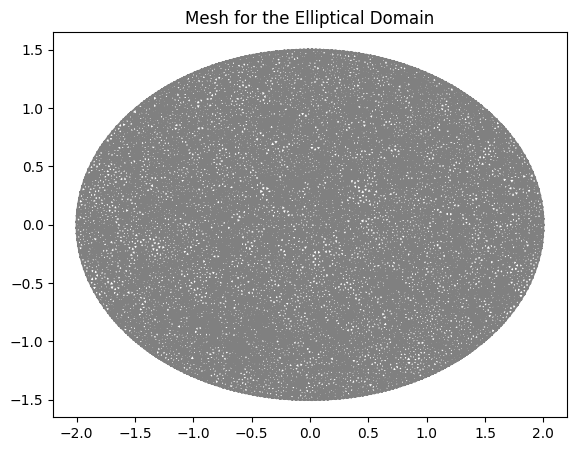

In [77]:

# Plot the solution (using FEniCS plot backend which works in Colab with matplotlib)
plt.figure(figsize=(7, 5))
p = plot(u_sol, title="FEM Solution for τ", mode="color")
plt.colorbar(p)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Optionally, you can also plot the mesh to see how the ellipse was discretized.
plt.figure(figsize=(7, 5))
plot(mesh)
plt.title("Mesh for the Elliptical Domain")
plt.show()

# 2) Adapted Architecture PINN